Amishi Gupta

23/CS/048

In [4]:
import numpy as np
import torch
import torchvision
from torchvision import transforms

torch.set_grad_enabled(False)
np.random.seed(42)

#load dataset
train_dataset =torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True
)

val_dataset= torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=64, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset, batch_size=64, shuffle=False)


In [5]:
#one hot
def one_hot(labels, num_classes=10):
    out = np.zeros((labels.size, num_classes))
    out[np.arange(labels.size), labels] = 1
    return out

#activations
def relu(z): return np.maximum(0, z)
def relu_deriv(z): return (z > 0).astype(float)

def sigmoid(z): return 1 / (1 + np.exp(-z))
def sigmoid_deriv(z): return sigmoid(z) * (1 - sigmoid(z))

def tanh(z): return np.tanh(z)
def tanh_deriv(z): return 1 - np.tanh(z)**2

def softmax(z):
    z -= np.max(z, axis=1, keepdims=True)
    exp = np.exp(z)
    return exp / np.sum(exp, axis=1, keepdims=True)


In [6]:
class NeuralNetwork:
    def __init__(self, layer_sizes, hidden_activation="relu", lr=0.01):
        self.layer_sizes = layer_sizes
        self.lr = lr
        self.num_layers = len(layer_sizes) - 1

        #choose hidden activation
        if hidden_activation == "relu":
            self.act = relu
            self.act_deriv = relu_deriv
        elif hidden_activation == "sigmoid":
            self.act = sigmoid
            self.act_deriv = sigmoid_deriv
        elif hidden_activation == "tanh":
            self.act = tanh
            self.act_deriv = tanh_deriv
        else:
            raise ValueError("Bad activation")

        #initialize parameters
        self.W = []
        self.b = []
        for i in range(self.num_layers):
            w = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2/layer_sizes[i])
            b = np.zeros((1, layer_sizes[i+1]))
            self.W.append(w)
            self.b.append(b)

    #forward
    def forward(self, X):
        self.z = []
        self.a = [X]

        for i in range(self.num_layers - 1):
            z = self.a[-1] @ self.W[i] + self.b[i]
            a = self.act(z)
            self.z.append(z)
            self.a.append(a)

        #output layer
        z = self.a[-1] @ self.W[-1] + self.b[-1]
        y_hat = softmax(z)

        self.z.append(z)
        self.a.append(y_hat)
        return y_hat

    #loss
    def compute_loss(self, y_hat, y_true):
        m = y_true.shape[0]
        return -np.sum(y_true * np.log(y_hat + 1e-8)) / m

    #backprop
    def backward(self, y_hat, y_true):
        m = y_true.shape[0]
        grads_W, grads_b = [], []

        #output layer
        dz = (y_hat - y_true) / m
        dw = self.a[-2].T @ dz
        db = np.sum(dz, axis=0, keepdims=True)

        grads_W.append(dw)
        grads_b.append(db)

        #hidden layers
        for i in range(self.num_layers - 2, -1, -1):
            dz = (dz @ self.W[i+1].T) * self.act_deriv(self.z[i])
            dw = self.a[i].T @ dz
            db = np.sum(dz, axis=0, keepdims=True)

            grads_W.append(dw)
            grads_b.append(db)

        grads_W.reverse()
        grads_b.reverse()

        return grads_W, grads_b

    #update
    def update_parameters(self, grads_W, grads_b):
        for i in range(self.num_layers):
            self.W[i] -= self.lr * grads_W[i]
            self.b[i] -= self.lr * grads_b[i]

    #predict
    def predict(self, X):
        return np.argmax(self.forward(X), axis=1)

    #evaluate
    def evaluate(self, loader):
        total, correct, loss_sum = 0, 0, 0

        with torch.no_grad():
            for images, labels in loader:
                images_np = images.cpu().numpy().reshape(images.shape[0], -1)
                labels_np = labels.cpu().numpy()
                labels_oh = one_hot(labels_np)

                y_hat = self.forward(images_np)
                loss_sum += self.compute_loss(y_hat, labels_oh)

                preds = np.argmax(y_hat, axis=1)
                correct += np.sum(preds == labels_np)
                total += labels_np.size

        return loss_sum / len(loader), correct / total


In [7]:
def train(model, train_loader, val_loader, epochs=5):
    history = {
        "train_loss": [], "train_acc": [],
        "val_loss": [], "val_acc": []
    }

    for epoch in range(epochs):
        train_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in train_loader:
                X = images.cpu().numpy().reshape(images.shape[0], -1)
                Y = labels.cpu().numpy()
                Y_oh = one_hot(Y)

                y_hat = model.forward(X)
                loss = model.compute_loss(y_hat, Y_oh)
                grads_W, grads_b = model.backward(y_hat, Y_oh)
                model.update_parameters(grads_W, grads_b)

                train_loss += loss
                correct += np.sum(np.argmax(y_hat, axis=1) == Y)
                total += len(Y)

        train_acc = correct / total
        val_loss, val_acc = model.evaluate(val_loader)

        history["train_loss"].append(train_loss/len(train_loader))
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss/len(train_loader):.4f} | "
              f"Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    return history


In [8]:
model = NeuralNetwork(
    layer_sizes=[784, 128, 128, 10],
    hidden_activation="relu",
    lr=0.01
)

history = train(model, train_loader, val_loader, epochs=10)


Epoch 1/10 | Train Loss: 0.7270 | Train Acc: 0.8125 | Val Loss: 0.3665 | Val Acc: 0.8981
Epoch 2/10 | Train Loss: 0.3385 | Train Acc: 0.9041 | Val Loss: 0.2907 | Val Acc: 0.9170
Epoch 3/10 | Train Loss: 0.2845 | Train Acc: 0.9184 | Val Loss: 0.2623 | Val Acc: 0.9246
Epoch 4/10 | Train Loss: 0.2519 | Train Acc: 0.9286 | Val Loss: 0.2300 | Val Acc: 0.9348
Epoch 5/10 | Train Loss: 0.2275 | Train Acc: 0.9349 | Val Loss: 0.2123 | Val Acc: 0.9395
Epoch 6/10 | Train Loss: 0.2076 | Train Acc: 0.9408 | Val Loss: 0.1948 | Val Acc: 0.9443
Epoch 7/10 | Train Loss: 0.1909 | Train Acc: 0.9459 | Val Loss: 0.1811 | Val Acc: 0.9471
Epoch 8/10 | Train Loss: 0.1769 | Train Acc: 0.9499 | Val Loss: 0.1757 | Val Acc: 0.9487
Epoch 9/10 | Train Loss: 0.1652 | Train Acc: 0.9533 | Val Loss: 0.1598 | Val Acc: 0.9526
Epoch 10/10 | Train Loss: 0.1547 | Train Acc: 0.9562 | Val Loss: 0.1530 | Val Acc: 0.9544


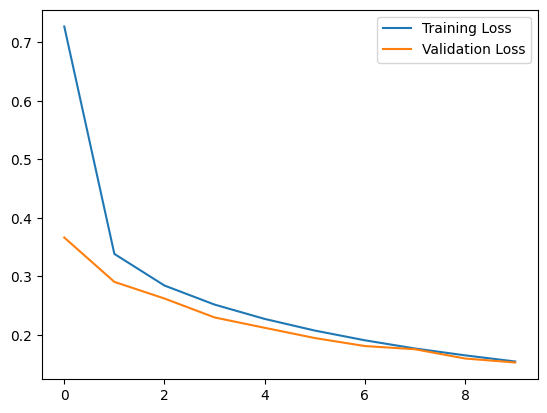

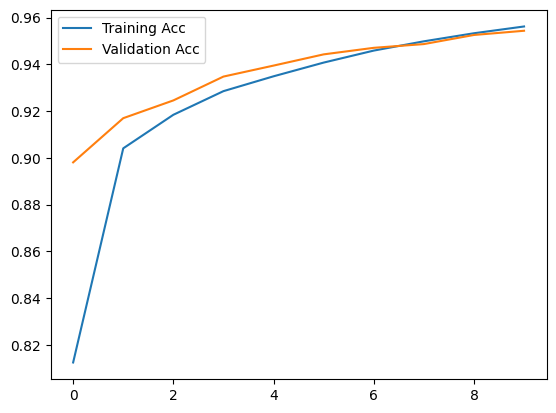

In [9]:
import matplotlib.pyplot as plt

plt.plot(history["train_loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

plt.plot(history["train_acc"], label="Training Acc")
plt.plot(history["val_acc"], label="Validation Acc")
plt.legend()
plt.show()
